In [67]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassAccuracy

In [68]:
with open("../data/train.pkl", "rb") as f:
    train_data = pickle.load(f)

In [69]:
train_data

[(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0),
 (array([ -1.,  -1., 144., ...,  32.,  -1.,  -1.]), 0),
 (array([ 66., 100., 148., 148., 146.,  64., 146., 148.,  82.,   0.,  82.,
         100.,  34., 132., 180.,  65.,  80.,  81., 131.,  52.,  34.,  52.,
          64.,  52.,   3.,  66., 147.,  20.,   4., 132., 132., 100., 111.,
          74., 110.,  60.,  92.,  65., 100., 189.,  44.,   8.,   5.,  76.,
          31., 159.,   5., 124.,   4.,  12.,  51., 157.,  57.,  31., 183.,
          57.,  65.,  92.,  69., 124., 122.,  79., 110.,  76.,  12.,  12.,
          12.,  12.,   8., 159.,  12., 156., 100., 111.,  52., 121.,  36.,
          47.,  41.,  41.,   8., 172.,  38.,  12.,  78.,  12.,  88.,  47.,
         119.,  20.,  47.,  12., 159.,  20.,  20.,  76.,  60., 110., 132.,
         185., 120.,  45., 110., 110.,  72., 124., 178.,  73.,   8.,  78.,
          12.,  42., 173.,  12., 150.,  84.,  66., 152.,  69.,   8.,  41.,
         159.,   5.,  78.,  44., 180.,  71.,  92., 152.,   6., 

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [71]:
df = pd.DataFrame(train_data, columns = ["Sequence", "Author"])

In [72]:
df["Author"].value_counts()

Author
0    1630
1     478
3     441
4     236
2     154
Name: count, dtype: int64

In [73]:
class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(x, dtype=torch.float32) for x in X]
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [74]:
scaler = StandardScaler()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df["Sequence"], df["Author"], test_size = 0.2, random_state = 42)

In [76]:
X_train

456     [80.0, 80.0, 80.0, 158.0, 92.0, 92.0, 93.0, 12...
462     [0.0, 47.0, 47.0, 157.0, 28.0, 28.0, 12.0, 0.0...
2216    [-1.0, -1.0, -1.0, 0.0, 12.0, 125.0, 12.0, 12....
2668    [144.0, 144.0, 34.0, 68.0, 20.0, 32.0, 146.0, ...
381     [64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64...
                              ...                        
1638    [-1.0, -1.0, 112.0, 0.0, 0.0, 117.0, 12.0, 12....
1095    [0.0, 82.0, 148.0, 148.0, 132.0, 3.0, 6.0, 8.0...
1130    [-1.0, -1.0, -1.0, 0.0, 5.0, 13.0, 78.0, 12.0,...
1294    [12.0, 12.0, 12.0, 12.0, 47.0, 44.0, 44.0, 44....
860     [-1.0, -1.0, 0.0, 0.0, 0.0, 13.0, 172.0, 92.0,...
Name: Sequence, Length: 2351, dtype: object

In [77]:
# X_train = X_train.apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

print(X_train)

456     [80.0, 80.0, 80.0, 158.0, 92.0, 92.0, 93.0, 12...
462     [0.0, 47.0, 47.0, 157.0, 28.0, 28.0, 12.0, 0.0...
2216    [-1.0, -1.0, -1.0, 0.0, 12.0, 125.0, 12.0, 12....
2668    [144.0, 144.0, 34.0, 68.0, 20.0, 32.0, 146.0, ...
381     [64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64...
                              ...                        
1638    [-1.0, -1.0, 112.0, 0.0, 0.0, 117.0, 12.0, 12....
1095    [0.0, 82.0, 148.0, 148.0, 132.0, 3.0, 6.0, 8.0...
1130    [-1.0, -1.0, -1.0, 0.0, 5.0, 13.0, 78.0, 12.0,...
1294    [12.0, 12.0, 12.0, 12.0, 47.0, 44.0, 44.0, 44....
860     [-1.0, -1.0, 0.0, 0.0, 0.0, 13.0, 172.0, 92.0,...
Name: Sequence, Length: 2351, dtype: object


In [78]:
# X_test = X_test.apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

In [79]:
train_dataset = pd.concat([X_train, y_train], axis =1)
v_dataset = pd.concat([X_test, y_test], axis = 1)

In [80]:
type(v_dataset.iloc[:, 1])

pandas.core.series.Series

In [81]:
type(train_dataset.iloc[:, 1])

pandas.core.series.Series

In [82]:
valid_dataset = MusicDataset(v_dataset.iloc[:,0], v_dataset.iloc[:, 1])
train_dataset = MusicDataset(train_dataset.iloc[:,0], train_dataset.iloc[:, 1])

In [83]:
print(type(train_dataset[10]))
print(train_dataset[10])

<class 'tuple'>
(tensor([  2.,  36.,  68., 116., 148.,   1.,  82.,  50.,  84.,  21.,  92., 136.,
         92.,  14.,  28.,   9., 175.,  60., 108.,  13., 173., 175.,  92.,  92.,
        175.,  13.,  60., 126.,  12.,  12.,  14.,  95.,  13., 175., 126.,  92.,
         12., 126.,  92.,   0., 173.,  13.,  28.,  61.,  14.,  60., 136.,  92.,
         92., 175., 108.,  28.,  61.,   9., 108., 125.,  13., 126.,  92.,  68.,
          2.,  65., 180.,  28.,  12.,  12., 126.,  28.,  95.,  61.,  14.,  13.,
         60.,  93.,  60., 126., 175., 111.,  28., 158., 158.,  92.,  93.,  12.,
         95., 140., 175.,  15., 140.,  14.,  92., 159.,  93., 180.,  12., 126.,
         12.,   1.,  46.,  42.,  95.,  95., 140.,  12.,  12.,  12.,  28.,  12.,
         42.,  42.,  12., 140.,  12.,  12., 126.,  28.,  12.,  28.,  60.,  29.,
         15.,  12.,  12.,   8., 125.,  60.,  28.,  60.,  12.,  60.,  95.,  12.,
         12., 185., 119.,  95.,  95.,  56., 140., 108.,  95.,  92.,  36.,   2.,
         68., 140., 140

In [84]:
class LSTMClasifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size, out_size)
        self.act =  nn.LeakyReLU()

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, x_lens, hidden):
        # x = torch.transpose(x,0,1)
        x_packed = pack_padded_sequence(x, x_lens, batch_first=False, enforce_sorted=False)
        all_outputs, hidden = self.lstm(x_packed, hidden)
        preds, pred_len = pad_packed_sequence(all_outputs, batch_first=False, padding_value=0)
        # all_outputs = torch.transpose(all_outputs,0,1)
        # out = torch.flatten(all_outputs,1)
        # print(all_outputs.shape)
        # all_outputs = torch.transpose(all_outputs,0,1)
        x = self.act(self.fc(hidden[0][-1]))
        return x, hidden

In [85]:
df["Author"].nunique()

5

In [86]:
hidden_dim = 512
layer_dim = 8
input_dim = 1
out_dim = df["Author"].nunique()
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, out_dim)
model.to(device)


LSTMClassifier(
  (lstm): LSTM(1, 512, num_layers=8, dropout=0.6)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

In [87]:
weights = 1.0 / torch.from_numpy(df["Author"].value_counts().values)
weights = weights / weights.sum()  
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), 0.001)
loss_fun = nn.CrossEntropyLoss(weights.to(device))

In [88]:


pad = -10000

# Wyrównanie sekwencji w mini batch
def pad_collate(batch, pad_value=pad):
    xx, yy = zip(*batch)
    x_lens = [len(x) if x.dim() > 0 else 0 for x in xx]
    y_lens = [len(y) if y.dim() > 0 else 0 for y in yy]

    xx = [x.unsqueeze(0) if x.dim() == 0 else x for x in xx]
    yy = [y.unsqueeze(0) if y.dim() == 0 else y for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [89]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn = pad_collate)
train_dataset[10]

(tensor([  2.,  36.,  68., 116., 148.,   1.,  82.,  50.,  84.,  21.,  92., 136.,
          92.,  14.,  28.,   9., 175.,  60., 108.,  13., 173., 175.,  92.,  92.,
         175.,  13.,  60., 126.,  12.,  12.,  14.,  95.,  13., 175., 126.,  92.,
          12., 126.,  92.,   0., 173.,  13.,  28.,  61.,  14.,  60., 136.,  92.,
          92., 175., 108.,  28.,  61.,   9., 108., 125.,  13., 126.,  92.,  68.,
           2.,  65., 180.,  28.,  12.,  12., 126.,  28.,  95.,  61.,  14.,  13.,
          60.,  93.,  60., 126., 175., 111.,  28., 158., 158.,  92.,  93.,  12.,
          95., 140., 175.,  15., 140.,  14.,  92., 159.,  93., 180.,  12., 126.,
          12.,   1.,  46.,  42.,  95.,  95., 140.,  12.,  12.,  12.,  28.,  12.,
          42.,  42.,  12., 140.,  12.,  12., 126.,  28.,  12.,  28.,  60.,  29.,
          15.,  12.,  12.,   8., 125.,  60.,  28.,  60.,  12.,  60.,  95.,  12.,
          12., 185., 119.,  95.,  95.,  56., 140., 108.,  95.,  92.,  36.,   2.,
          68., 140., 140.,  

In [90]:
first_batch = next(iter(train_loader))
print(len(first_batch))

4


In [91]:
EPOCHS_NUMBER = 100
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
model.train()
batch_num = 0
for epoch in tqdm_progress:
    train_losses = 0
    for x, targets, x_len, target_len in train_loader:
        x = torch.transpose(x, 0, 1)
        optimizer.zero_grad()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
    
        preds, _ = model(x,x_len, (hidden, state)) 
        print(preds)
        preds = preds.squeeze(1)
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_losses},

        }
    )

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-2.3878e-03, -3.9476e-02,  2.8631e-02,  3.6041e-02, -2.7874e-02],
        [ 7.9799e-05, -3.5286e-02,  3.1996e-02,  3.8864e-02, -2.5592e-02],
        [ 4.9252e-03, -4.2132e-02,  3.4804e-02,  3.3802e-02, -2.1240e-02],
        [ 1.6217e-03, -3.7362e-02,  2.9070e-02,  3.4126e-02, -2.1438e-02],
        [-1.9297e-03, -3.6101e-02,  2.9395e-02,  3.5828e-02, -2.5512e-02],
        [-3.8964e-03, -3.7367e-02,  2.9572e-02,  3.6435e-02, -2.5497e-02],
        [ 1.4223e-04, -3.8036e-02,  3.0299e-02,  3.6805e-02, -2.1668e-02],
        [-8.0295e-03, -3.6845e-02,  3.5529e-02,  3.4877e-02, -2.8960e-02],
        [-4.3351e-03, -3.3755e-02,  2.9751e-02,  3.5544e-02, -2.2781e-02],
        [ 8.8047e-04, -3.4575e-02,  2.6587e-02,  3.1653e-02, -2.4727e-02],
        [ 3.1483e-03, -3.5527e-02,  2.6491e-02,  3.2091e-02, -2.2611e-02],
        [ 4.5189e-03, -3.3999e-02,  2.7391e-02,  3.2999e-02, -2.1493e-02],
        [-2.7591e-03, -3.3832e-02,  2.4484e-02,  3.7267e-02, -2.0432e-02],
        [-2.4928e-03, -3.

  1%|          | 1/100 [00:26<44:00, 26.67s/it, Epoch=1, Los in train={113.2621237039566}]

tensor([[-0.0751, -0.0547, -0.6687,  0.4475,  0.2290],
        [-0.0647, -0.0252, -0.6586,  0.4132,  0.2064],
        [-0.0545, -0.0258, -0.6578,  0.3883,  0.2150],
        [-0.0797, -0.0449, -0.6406,  0.4249,  0.2080],
        [-0.0640, -0.0290, -0.7109,  0.4372,  0.2330],
        [-0.0701, -0.0229, -0.7388,  0.4512,  0.2410],
        [-0.0779, -0.0381, -0.6715,  0.4252,  0.2365],
        [-0.0959, -0.0651, -0.5909,  0.4222,  0.2343],
        [-0.0842, -0.0517, -0.6074,  0.4250,  0.2104],
        [-0.0613, -0.0301, -0.7478,  0.4387,  0.2311],
        [-0.1029, -0.0572, -0.7023,  0.4759,  0.2390],
        [-0.0798, -0.0581, -0.6872,  0.4485,  0.2420],
        [-0.0739, -0.0515, -0.6172,  0.4253,  0.2166],
        [-0.0318,  0.0011, -0.7212,  0.3934,  0.2102],
        [-0.0851, -0.0657, -0.6949,  0.4668,  0.2606]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-0.0686, -0.0334, -0.7535,  0.4567,  0.2487],
        [-0.0555, -0.0267, -0.6860,  0.4113,  0.2384],
        [-0.07

  2%|▏         | 2/100 [00:52<43:06, 26.39s/it, Epoch=2, Los in train={110.85496068000793}]

tensor([[ 0.0266, -0.0551, -0.7318,  0.3857,  0.2663],
        [ 0.0056, -0.0129, -0.6877,  0.3425,  0.2105],
        [ 0.0263, -0.0245, -0.6775,  0.3467,  0.2323],
        [-0.0123, -0.0992, -0.7775,  0.4447,  0.3511],
        [-0.0652, -0.1827, -0.7699,  0.4809,  0.4371],
        [-0.0359, -0.0906, -0.7139,  0.4286,  0.3076],
        [ 0.0771,  0.0256, -0.5839,  0.2538,  0.1613],
        [-0.1100, -0.2373, -0.9847,  0.6046,  0.5523],
        [-0.0100, -0.0742, -0.7650,  0.4189,  0.3147],
        [-0.0867, -0.1572, -1.0165,  0.6151,  0.4650],
        [-0.0806, -0.1564, -0.8859,  0.5440,  0.4447],
        [-0.0594, -0.1372, -0.8673,  0.5194,  0.4144],
        [-0.0644, -0.1519, -0.9574,  0.5663,  0.4876],
        [-0.0286, -0.0991, -0.7218,  0.4039,  0.3425],
        [-0.0235, -0.1121, -0.8693,  0.5021,  0.3620],
        [-0.0448, -0.1405, -0.8304,  0.5011,  0.4085],
        [-0.0237, -0.0971, -0.8248,  0.4819,  0.3328],
        [-0.0626, -0.1158, -0.9255,  0.5559,  0.3872],
        [-

  3%|▎         | 3/100 [01:20<43:14, 26.75s/it, Epoch=3, Los in train={110.47957909107208}]

tensor([[-0.1048, -0.2619, -1.1074,  0.7492,  0.3836],
        [-0.0083,  0.0581, -0.6929,  0.2401,  0.2643],
        [-0.0888, -0.1494, -1.2452,  0.7196,  0.3933],
        [ 0.2513,  0.3553, -0.7887, -0.1058,  0.1666],
        [ 0.1947,  0.2841, -0.8005,  0.0053,  0.1948],
        [ 0.1161,  0.2913, -0.8431,  0.0389,  0.2146],
        [-0.2778, -0.3773, -0.6005,  0.7214,  0.3156],
        [ 0.2346,  0.3713, -0.7159, -0.1416,  0.1418],
        [-0.0270,  0.0698, -1.0807,  0.3970,  0.2918],
        [ 0.1519,  0.2800, -0.9904,  0.1398,  0.2367],
        [-0.1379, -0.1760, -1.2631,  0.7541,  0.4112],
        [ 0.1842,  0.2069, -0.8852,  0.0846,  0.2238],
        [ 0.0850,  0.1335, -0.9413,  0.2090,  0.2853],
        [-0.0140, -0.2736, -0.9960,  0.7101,  0.3585],
        [ 0.0202,  0.1658, -0.9477,  0.2645,  0.2225],
        [-0.2432, -0.3869, -0.4344,  0.7074,  0.2038],
        [ 0.0930,  0.1487, -0.8551,  0.1719,  0.2403],
        [ 0.0563,  0.2132, -0.9062,  0.1997,  0.1930],
        [-

  4%|▍         | 4/100 [01:47<43:09, 26.98s/it, Epoch=4, Los in train={107.01872050762177}]

tensor([[ 0.3904,  0.2187, -0.9322, -0.1794,  0.3082],
        [ 0.4211,  0.2605, -0.8403, -0.2055,  0.2251],
        [-0.3093, -0.6288, -1.1338,  1.2366,  0.4987],
        [ 0.3937,  0.2529, -0.7964, -0.1879,  0.1965],
        [ 0.2503,  0.0755, -1.2381,  0.1452,  0.4212],
        [-0.0870, -0.4873, -1.2872,  0.9495,  0.5244],
        [-0.3949, -0.5322, -0.8066,  1.0249,  0.4369],
        [-0.3447, -0.5477, -0.7139,  1.0037,  0.3628],
        [ 0.5289,  0.3968, -0.9561, -0.4050,  0.2398],
        [ 0.6444,  0.4587, -0.7623, -0.5490,  0.1286],
        [ 0.4504,  0.2439, -0.9685, -0.1283,  0.2615],
        [-0.4216, -0.7337, -0.9330,  1.2426,  0.5246],
        [ 0.3650,  0.2580, -0.9373, -0.1647,  0.2618],
        [ 0.4575,  0.2820, -0.9740, -0.1893,  0.2475],
        [ 0.3777,  0.1610, -0.9222, -0.0098,  0.2575]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 0.3577,  0.2244, -0.9870, -0.1229,  0.3365],
        [-0.3675, -0.5215, -0.8173,  1.0354,  0.4116],
        [ 0.39

  5%|▌         | 5/100 [02:14<42:51, 27.07s/it, Epoch=5, Los in train={105.28651261329651}]

tensor([[-0.7305, -1.0152, -1.1691,  1.6110,  0.6807],
        [ 0.1754,  0.2494, -0.8000, -0.0745,  0.3039],
        [-0.6934, -1.0452, -1.0058,  1.5747,  0.6116],
        [-0.6076, -1.0387, -1.1833,  1.3959,  0.8217],
        [ 0.2085,  0.3113, -1.0284, -0.1841,  0.4314],
        [-0.5994, -0.9293, -0.9082,  1.2923,  0.6336],
        [ 0.1492,  0.2206, -0.8226, -0.0462,  0.3547],
        [ 0.2647,  0.3512, -0.9221, -0.2375,  0.3251],
        [ 0.1561,  0.3269, -0.9217, -0.0641,  0.3410],
        [ 0.2302,  0.3248, -0.9583, -0.1937,  0.3780],
        [ 0.2389,  0.3018, -0.9380, -0.1573,  0.4178],
        [ 0.2451,  0.2903, -0.8029, -0.2173,  0.3196],
        [ 0.2429,  0.4282, -0.9907, -0.1896,  0.2819],
        [ 0.2165,  0.3339, -1.0055, -0.1734,  0.3847],
        [-0.0648,  0.0665, -0.9039,  0.2380,  0.4204]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 0.3036,  0.4137, -0.7400, -0.2797,  0.2291],
        [-0.6380, -0.9738, -0.8437,  1.3308,  0.5623],
        [ 0.27

  6%|▌         | 6/100 [02:42<42:47, 27.32s/it, Epoch=6, Los in train={107.12954258918762}]

tensor([[-0.1572, -0.2334, -1.2418,  0.6379,  0.5637],
        [ 0.3025,  0.1697, -0.8940, -0.0425,  0.2289],
        [ 0.1557,  0.0645, -0.9825,  0.0871,  0.4008],
        [-0.2938, -0.9060, -1.5947,  1.3777,  0.8088],
        [ 0.2536,  0.0859, -0.8158,  0.0358,  0.2596],
        [ 0.3225,  0.2026, -0.6969, -0.1353,  0.1591],
        [ 0.0898,  0.0121, -0.9499,  0.1782,  0.3541],
        [ 0.2102,  0.1329, -0.8085, -0.0218,  0.2625],
        [ 0.2194,  0.1383, -0.8063,  0.0461,  0.2551],
        [ 0.2117,  0.0542, -0.7831,  0.0048,  0.2433],
        [ 0.2491,  0.1903, -0.6945, -0.0456,  0.1669],
        [-0.2599, -0.7412, -1.5319,  1.0482,  0.8344],
        [ 0.3161,  0.1973, -0.8428, -0.0176,  0.1897],
        [ 0.2177,  0.1355, -0.7330,  0.0796,  0.2122],
        [ 0.3641,  0.2661, -0.7911, -0.1431,  0.1826]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-0.3471, -0.8198, -1.6186,  1.4210,  0.7821],
        [-0.2690, -0.8625, -1.6404,  1.1948,  0.8384],
        [-0.37

  7%|▋         | 7/100 [03:09<42:23, 27.35s/it, Epoch=7, Los in train={105.69314980506897}]

tensor([[ 0.0079, -0.5204, -1.4811,  0.4022,  0.9341],
        [ 0.5687,  0.6510, -1.1599, -0.2103,  0.0071],
        [-0.3065, -0.6935, -1.2392,  0.9010,  0.8808],
        [-0.2725, -0.7768, -1.4382,  0.8724,  1.0499],
        [-0.0570, -0.3657, -1.2233,  0.4761,  0.6908],
        [-0.2746, -0.1003, -1.3790,  0.9714,  0.5118],
        [-0.4096, -0.0952, -1.5882,  1.3527,  0.4382],
        [ 0.4355,  0.5425, -1.2503, -0.1243,  0.1470],
        [ 0.5398,  0.6236, -1.2210, -0.1628,  0.0563],
        [-0.7030, -0.2496, -1.1112,  1.6464,  0.0686],
        [ 0.6361,  0.7877, -1.3471, -0.3548,  0.0226],
        [ 0.3768,  0.4578, -1.0602, -0.0554,  0.1499],
        [ 0.5196,  0.5941, -0.9089, -0.2268, -0.0844],
        [ 0.5346,  0.6394, -1.2425, -0.2040,  0.0468],
        [ 0.5644,  0.6780, -1.0194, -0.2992, -0.0542]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-0.3145, -0.5158, -1.0187,  0.7747,  0.7269],
        [-0.4137, -0.7459, -1.0827,  0.9866,  0.8558],
        [-0.24

  8%|▊         | 8/100 [03:36<41:36, 27.14s/it, Epoch=8, Los in train={106.81094813346863}]

tensor([[ 0.1571,  0.0871, -0.8270,  0.1460,  0.2237],
        [-0.2870, -0.3408, -0.4001,  0.4843,  0.1575],
        [ 0.5402,  0.5218, -0.8705, -0.1209, -0.1126],
        [ 0.1096,  0.1587, -0.9357,  0.1241,  0.2462],
        [ 0.1454,  0.0402, -0.5866,  0.1019,  0.1381],
        [ 0.1269,  0.0710, -0.8244,  0.1825,  0.2384],
        [-0.6932, -1.4100, -1.0370,  1.7418,  0.4952],
        [-0.0318, -0.0528, -0.6428,  0.1749,  0.2872],
        [ 0.5301,  0.4543, -0.8321, -0.0485, -0.1419],
        [ 0.5266,  0.4539, -0.9682, -0.1040, -0.0264],
        [ 0.1459,  0.0875, -0.6130,  0.0814,  0.1286],
        [ 0.1430,  0.1121, -0.8185,  0.1668,  0.2029],
        [ 0.4590,  0.3683, -0.7269, -0.0696, -0.0635],
        [ 0.4371,  0.3888, -0.7651, -0.0511, -0.0368],
        [ 0.3870,  0.2997, -0.6398, -0.0476, -0.0322]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-0.5982, -1.2395, -0.6962,  1.5693,  0.2047],
        [ 0.0787, -0.0032, -0.5660,  0.1368,  0.1862],
        [ 0.36

  9%|▉         | 9/100 [04:03<41:07, 27.12s/it, Epoch=9, Los in train={104.3578132390976}] 

tensor([[ 7.3896e-01,  7.2490e-01, -1.3346e+00, -1.6696e-01,  3.8002e-03],
        [-3.5437e-01, -3.1950e-01, -9.1187e-01,  7.3518e-01,  4.0969e-01],
        [ 4.0594e-01,  4.0068e-01, -9.2440e-01, -9.2772e-02,  1.2999e-01],
        [-1.6345e-01,  2.1618e-02, -9.2681e-01,  1.7145e-01,  4.8911e-01],
        [ 6.1269e-01,  5.5915e-01, -9.0367e-01, -1.8618e-01, -4.4868e-02],
        [-3.9724e-01, -7.0498e-01, -9.5078e-01,  1.0236e+00,  5.4727e-01],
        [ 4.3262e-01,  4.8825e-01, -9.9640e-01, -6.3234e-02,  6.3812e-02],
        [-1.1810e-01,  1.4807e-01, -1.2882e+00,  1.6336e-01,  6.1318e-01],
        [ 7.1013e-01,  7.0110e-01, -1.1569e+00, -2.2375e-01, -6.6569e-03],
        [-3.9038e-01, -2.9340e-01, -1.1431e+00,  8.5850e-01,  5.4223e-01],
        [-4.0326e-02, -3.7722e-01, -1.5314e+00,  5.4993e-01,  7.3726e-01],
        [-3.4644e-01, -8.3399e-01, -1.2006e+00,  9.2279e-01,  7.2376e-01],
        [ 6.6246e-01,  6.1924e-01, -1.0313e+00, -2.3587e-01,  2.7374e-02],
        [ 7.7566e-01,  7.

 10%|█         | 10/100 [04:30<40:37, 27.09s/it, Epoch=10, Los in train={102.92166447639465}]

tensor([[-0.0664,  0.2304, -1.4937,  0.5043,  0.5444],
        [ 0.2134, -0.5562, -1.6614,  0.0819,  1.0317],
        [-0.1153, -0.0258, -1.4680,  0.8880,  0.4226],
        [ 0.8901,  0.8445, -1.1406, -0.3355, -0.2227],
        [ 0.8196,  0.8607, -1.1359, -0.2060, -0.2247],
        [ 0.5100,  0.5173, -0.6922, -0.1456, -0.0718],
        [ 0.0076, -0.6857, -1.4270,  0.4925,  0.9447],
        [ 0.5220,  0.5744, -0.8100, -0.1528, -0.0714],
        [ 0.1621,  0.2240, -0.9498, -0.1448,  0.4491],
        [-0.0318,  0.0036, -0.9159,  0.1332,  0.4584],
        [-0.0739, -0.6024, -1.3987,  0.7225,  0.7868],
        [ 0.2299, -0.7747, -1.9690,  0.3177,  1.2553],
        [ 0.8176,  0.7990, -1.1405, -0.2512, -0.1691],
        [ 0.2746,  0.0267, -1.2840, -0.1942,  0.6475],
        [-0.3479, -1.2056, -0.9367,  1.1637,  0.4854],
        [ 0.1686,  0.2588, -1.1623, -0.1826,  0.5530],
        [ 0.2517,  0.3877, -1.4070, -0.2236,  0.6039],
        [ 0.7740,  0.7577, -1.0244, -0.2302, -0.2180],
        [ 

 11%|█         | 11/100 [04:59<40:59, 27.64s/it, Epoch=11, Los in train={102.5823415517807}] 

tensor([[-0.1962, -0.4198, -1.4011,  0.4975,  0.9244],
        [ 0.4409,  0.4896, -0.9627, -0.1106,  0.0618],
        [ 0.7692,  0.7313, -1.2676, -0.0467, -0.1555],
        [ 0.1753,  0.3351, -0.6164, -0.0030,  0.0674],
        [ 0.7262,  0.6528, -1.3102, -0.0262, -0.0973],
        [-0.1496, -0.4025, -1.3806,  0.3690,  0.9428],
        [ 0.3686,  0.3995, -0.8451, -0.0544,  0.0956],
        [ 0.0124,  0.2328, -0.7467, -0.2332,  0.4997],
        [-0.3277, -0.4100, -0.7597,  0.8160,  0.4055],
        [-0.2298,  0.0729, -0.8533,  0.1433,  0.5553],
        [-0.2523, -0.4855, -1.0133,  0.5803,  0.6777],
        [-0.2984,  0.0093, -1.2121,  0.6300,  0.5027],
        [-0.1039, -0.4685, -1.2134,  0.4325,  0.7620],
        [ 0.3140,  0.4476, -0.8514,  0.0179,  0.0455],
        [-0.0406, -0.2789, -1.5507,  0.2234,  1.0141]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-2.7277e-01,  6.7801e-02, -1.1996e+00,  6.0497e-01,  4.2261e-01],
        [ 1.8765e-01,  3.3304e-01, -5.4602e-01, -

 12%|█▏        | 12/100 [05:26<40:13, 27.43s/it, Epoch=12, Los in train={106.32683992385864}]

tensor([[-0.6102, -0.2702, -0.6096,  0.8202,  0.0697],
        [ 0.1489,  0.3145, -1.0477, -0.0560,  0.2480],
        [-0.2806, -0.6907, -1.3032,  0.5527,  0.9267],
        [-0.6595, -0.2984, -1.1830,  1.0026,  0.4813],
        [ 0.0303,  0.1939, -1.3062,  0.1283,  0.3201],
        [ 0.4231,  0.6227, -1.1696, -0.1300,  0.0147],
        [ 0.2787,  0.4646, -0.9321, -0.1169,  0.0745],
        [-0.6254, -0.6029, -0.6538,  1.4525,  0.0227],
        [-0.1016,  0.1738, -1.3601,  0.0897,  0.5277],
        [-0.6087, -0.1260, -0.6493,  0.6449,  0.1172],
        [-0.3313, -0.9266, -1.4337,  0.7557,  1.0234],
        [-0.4872, -0.3434, -0.9858,  0.8385,  0.4675],
        [-0.6311, -0.2123, -0.6775,  0.7354,  0.1683],
        [-0.1327,  0.1651, -0.9129,  0.0641,  0.3136],
        [ 0.3282,  0.5499, -1.0392, -0.0439,  0.0412],
        [ 0.7323,  0.7859, -1.5709, -0.2027,  0.0154],
        [-0.6581, -0.6497, -0.5087,  1.3407,  0.0203],
        [ 0.1203,  0.2960, -1.2659, -0.1116,  0.4442],
        [ 

 13%|█▎        | 13/100 [05:53<39:46, 27.43s/it, Epoch=13, Los in train={105.63306081295013}]

tensor([[ 0.3075,  0.0698, -1.6660,  0.5921,  0.3148],
        [ 0.4166,  0.0794, -1.7076,  0.4187,  0.3407],
        [ 0.3659,  0.0590, -1.6826,  0.5039,  0.2959],
        [-0.0834, -0.0894, -1.1157,  0.4966,  0.3575],
        [ 0.3508,  0.1346, -1.5396,  0.4698,  0.2251],
        [ 0.4479,  0.1618, -1.7826,  0.4885,  0.2801],
        [ 0.3321,  0.0175, -1.6788,  0.5355,  0.3306],
        [ 0.0220, -0.0897, -1.6219,  0.6326,  0.4670],
        [ 0.3210,  0.1277, -1.5713,  0.5086,  0.2262],
        [ 0.3424,  0.0554, -1.4990,  0.4153,  0.2340],
        [ 0.3860,  0.1116, -1.5189,  0.4158,  0.2221],
        [ 0.3848,  0.0977, -1.2287,  0.2943,  0.2106],
        [ 0.4369,  0.0832, -1.8777,  0.5012,  0.3167],
        [-0.0948, -0.0753, -1.3879,  0.6751,  0.3798],
        [ 0.3940,  0.0314, -1.5620,  0.4600,  0.2367]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2850,  0.1219, -1.5454,  0.6219,  0.1661],
        [ 0.3073,  0.1637, -1.7070,  0.6640,  0.2113],
        [ 0.34

 14%|█▍        | 14/100 [06:20<39:09, 27.32s/it, Epoch=14, Los in train={109.84541738033295}]

tensor([[ 2.9587e-01,  5.2592e-01, -1.5377e+00,  4.9017e-01,  3.1201e-02],
        [ 2.8617e-01,  3.9444e-01, -9.7511e-01,  2.1942e-01, -8.0112e-03],
        [ 2.9753e-01,  4.7221e-01, -1.2511e+00,  3.5413e-01,  8.1969e-03],
        [ 3.9351e-01,  4.7419e-01, -9.6545e-01,  1.4320e-01, -7.0388e-02],
        [ 2.0390e-01,  4.5383e-01, -1.4295e+00,  5.0747e-01,  6.2954e-02],
        [ 4.7666e-01,  6.2714e-01, -1.1968e+00,  1.9911e-01, -7.6337e-02],
        [ 3.3126e-01,  4.8825e-01, -1.1591e+00,  2.5400e-01,  3.8499e-02],
        [ 3.7310e-01,  5.6838e-01, -1.4135e+00,  3.3044e-01,  3.0613e-02],
        [ 8.1578e-02,  3.3306e-01, -1.4257e+00,  5.5397e-01,  1.0926e-01],
        [ 3.7060e-01,  4.8859e-01, -1.2027e+00,  2.4446e-01, -1.3765e-02],
        [ 2.9681e-01,  4.4374e-01, -1.2522e+00,  3.1816e-01,  2.8602e-02],
        [ 4.2416e-01,  5.5748e-01, -1.5073e+00,  3.5127e-01,  4.6680e-02],
        [ 4.0974e-01,  6.4168e-01, -1.4211e+00,  4.0018e-01, -8.8578e-02],
        [-2.9662e-01, -9.

 15%|█▌        | 15/100 [06:49<39:04, 27.58s/it, Epoch=15, Los in train={108.01553893089294}]

tensor([[ 0.3167,  0.2438, -0.9172,  0.2562, -0.0903],
        [-0.2154, -0.2959, -1.0853,  0.5860,  0.3081],
        [ 0.1138,  0.0523, -1.0614,  0.4212,  0.0381],
        [ 0.0962,  0.0845, -1.1536,  0.5089,  0.0605],
        [-0.4326, -0.5287, -1.0061,  0.7370,  0.4426],
        [-0.3899, -0.5277, -1.1815,  0.8036,  0.4569],
        [-0.5187, -0.6995, -1.1783,  0.8573,  0.5132],
        [ 0.2616,  0.2735, -1.1439,  0.3989, -0.0391],
        [ 0.3557,  0.3160, -1.1683,  0.3350, -0.1171],
        [ 0.1437,  0.1352, -1.0631,  0.3970,  0.0394],
        [ 0.2729,  0.1917, -1.0816,  0.3136,  0.0206],
        [ 0.1340,  0.1374, -1.0793,  0.3673,  0.0169],
        [-0.4480, -0.6351, -1.0872,  0.7831,  0.4350],
        [-0.4514, -0.6193, -1.2271,  0.8726,  0.4934],
        [-0.5328, -0.7567, -1.3433,  0.8728,  0.5929],
        [-0.5090, -0.5778, -1.1907,  0.8388,  0.5284],
        [-0.4596, -0.5828, -1.2272,  0.8535,  0.5101],
        [ 0.1353,  0.0718, -1.0588,  0.3688,  0.0997],
        [-

 15%|█▌        | 15/100 [06:51<38:51, 27.43s/it, Epoch=15, Los in train={108.01553893089294}]


KeyboardInterrupt: 

In [36]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn = pad_collate)
valid_dataset[10]

(tensor([ -1.,  -1.,  -1.,  12.,  12.,  12.,  47., 172.,  78.,  64.,  64.,  64.,
         141.,  79.,  76.,  76., 156.,  64., 159.,  92.,  13., 159.,  12., 157.,
          92.,   5.,   5.,   0.,  12., 124., 124., 124., 141., 141.,  12.,  12.,
          78.,  78.,  78.,  64.,  77., 124.,  78.,  78.,  12.,  12.,  69., 152.,
          64.,  64., 159.,  28.,  13.,  13., 159.,  12.,  78.,  78.,  47.,  78.,
          12., 145., 145.,  69.,  69., 159.,  28., 172.,  78.,  64.,  64.,  64.,
          12.,  15.,  76., 154., 156.,  64.,  64.,  64.]),
 tensor(0))

In [44]:
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for x, targets, x_len, target_len in train_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_train, _ = model(x,x_len, (hidden, state)) 
        predicts_train = predicts_train.squeeze(1)
        predicts_train_argmax = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, targets))
        predicted_train = torch.cat((predicted_train, predicts_train_argmax))
    for x, targets, x_len, target_len in valid_loader:
        x = torch.transpose(x, 0, 1)
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device).squeeze(1)
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device)
        predicts_val, _ = model(x,x_len, (hidden, state)) 
        predicts_val = predicts_val.squeeze(1)
        predicts_val_argmax = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, targets))
        predicted_val = torch.cat((predicted_val, predicts_val_argmax))

In [58]:
labels_train = labels_train.cpu()
predicted_train = predicted_train.cpu()
labels_val = labels_val.cpu()
predicted_val = predicted_val.cpu()


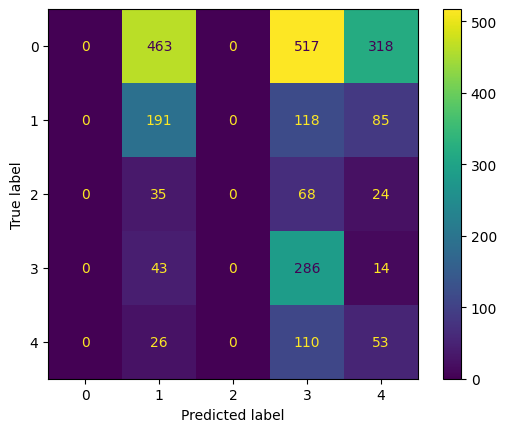

In [59]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [60]:
f1_score(labels_train, predicted_train, average='micro')

0.22543598468736709

In [61]:
mca_eval = MulticlassAccuracy(num_classes=6, average=None)

In [62]:
mca_eval(predicted_train, labels_train)

tensor([0.0000, 0.4848, 0.0000, 0.8338, 0.2804, 0.0000])

In [63]:
f1_score(labels_val, predicted_val, average='micro')

0.2227891156462585

In [64]:
mca_eval(predicted_val, labels_val)

tensor([0.0000, 0.5476, 0.0000, 0.7653, 0.2128, 0.0000])

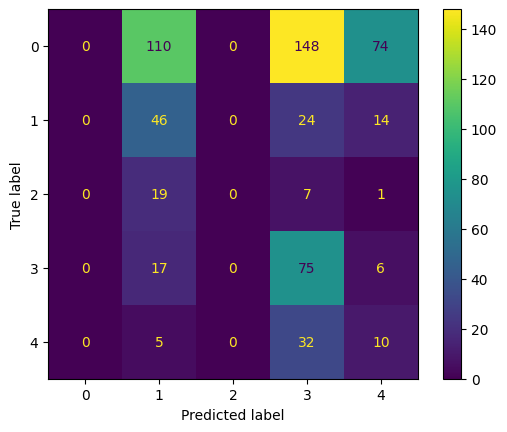

In [66]:
confusion_matrix_val = confusion_matrix(labels_val , predicted_val)
ConfusionMatrixDisplay(confusion_matrix_val).plot()
plt.show()